# Attention Is All You Need: Building a Swedish to English Translator From Scratch

## Part 1: Model

In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
random = tf.random.Generator.from_seed(1234)

### Word Embeddings

In [6]:
class WordEmbeddingsLayer(tf.keras.layers.Layer):

    def __init__(self,
                 d_model,
                 vocab_size,
                 name="word_embeddings_layer",
                 **kwargs):
        super().__init__(name=name, **kwargs)
        self.d_model = d_model
        self.word_embeddings = tf.keras.layers.Embedding(
            vocab_size, d_model, name="keras_word_embeddings_layer")

    @tf.function
    def call(self, inputs):
        """
        inputs: (batch_size, seq_len)

        outputs: (batch_size, seq_len, d_model)
        """
        outputs = tf.multiply(self.word_embeddings(inputs),
                              tf.sqrt(tf.cast(self.d_model, tf.float32)))
        return outputs

In [7]:
def test_word_embeddings_layer():
    word_embeddings = WordEmbeddingsLayer(d_model=512, vocab_size=10000)
    inputs = random.uniform((32, 100), maxval=10000, dtype=tf.int64)
    outputs = word_embeddings(inputs)

    print(f"inputs shape: {inputs.shape}")
    print(f"outputs shape: {outputs.shape}")

In [8]:
test_word_embeddings_layer()

inputs shape: (32, 100)
outputs shape: (32, 100, 512)


### Positional Encodings

In [9]:
@tf.function
def positional_encodings(seq_len, d_model):
    # (seq_len,)
    positions = tf.range(seq_len, dtype=tf.float32)
    # (seq_len, 1)
    positions = tf.expand_dims(positions, -1)
    # (d_model,)
    features = tf.range(d_model, dtype=tf.float32)
    features = tf.floor(tf.divide(features, 2.0))
    # (1, d_model)
    features = tf.expand_dims(features, 0)
    # (seq_len, d_model)
    angles = tf.divide(
        positions,
        tf.pow(
            10000.0,
            tf.divide(tf.multiply(2.0, features), tf.cast(d_model,
                                                          tf.float32))))

    even = tf.range(0, d_model, 2)
    odd = tf.range(1, d_model, 2)

    # (seq_len, d_model)
    encodings = tf.transpose(
        tf.dynamic_stitch((even, odd),
                          (tf.sin(tf.gather(tf.transpose(angles), even)),
                           tf.cos(tf.gather(tf.transpose(angles), odd)))))
    # (1, seq_len, d_model)
    encodings = tf.expand_dims(encodings, 0)

    return encodings

In [10]:
def test_positional_encodings():
    encodings = positional_encodings(seq_len=100, d_model=64)
    encodings = tf.squeeze(encodings, 0)
    encodings = tf.transpose(encodings)

    plt.figure(figsize=(8, 6))
    plt.imshow(encodings, cmap="RdBu", interpolation="nearest", vmin=-1, vmax=1)
    plt.gca().invert_yaxis()
    plt.xlabel("Position", fontsize="large")
    plt.ylabel("Depth", fontsize="large")
    plt.colorbar()
    plt.savefig("encodings.svg")

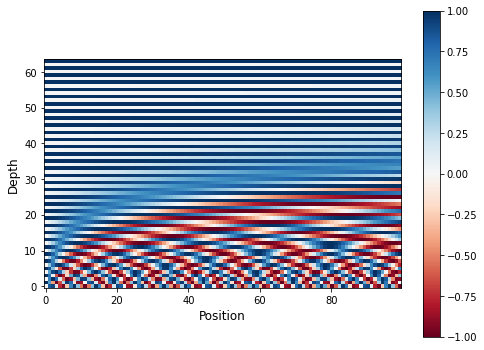

In [11]:
test_positional_encodings()

In [12]:
class PositionalEncodingsLayer(tf.keras.layers.Layer):

    def __init__(self,
                 dropout_rate,
                 name="positional_encodings_layer",
                 **kwargs):
        super().__init__(name=name, **kwargs)
        self.dropout = tf.keras.layers.Dropout(dropout_rate,
                                               name="keras_dropout_layer")

    @tf.function
    def call(self, inputs, training=False):
        """
        inputs: (batch_size, seq_len, d_model)

        outputs: (batch_size, seq_len, d_model)
        """
        seq_len = tf.shape(inputs)[1]
        d_model = tf.shape(inputs)[2]
        encodings = positional_encodings(seq_len, d_model)
        outputs = tf.add(inputs, encodings)
        outputs = self.dropout(outputs, training)
        return outputs

In [13]:
def test_positional_encodings_layer():
    pe_layer = PositionalEncodingsLayer(dropout_rate=0.1)
    inputs = random.normal((32, 100, 512))
    outputs = pe_layer(inputs)

    print(f"inputs shape: {inputs.shape}")
    print(f"outputs shape: {outputs.shape}")

In [14]:
test_positional_encodings_layer()

inputs shape: (32, 100, 512)
outputs shape: (32, 100, 512)


### Scaled Dot-Product Attention

In [15]:
@tf.function
def scaled_dot_product_attention(queries, keys, values, mask=None):
    """
    queries: (..., seq_len_q, d_k)
    keys: (..., seq_len_k, d_k)
    values: (..., seq_len_k, d_v)
    mask: (..., seq_len_q, seq_len_k)

    attn: (..., seq_len_q, d_v)
    attn_weights: (..., seq_len_q, seq_len_k)
    """
    d_k = tf.shape(keys)[-1]
    logits = tf.divide(tf.matmul(queries, keys, transpose_b=True),
                       tf.sqrt(tf.cast(d_k, tf.float32)))
    if mask is not None:
        logits = tf.subtract(logits, tf.multiply(mask, 1e9))
    attn_weights = tf.nn.softmax(logits)
    attn = tf.matmul(attn_weights, values)
    return attn, attn_weights

In [16]:
def test_scaled_dot_product_attention():

    def test_queries(queries):
        keys = tf.constant([[10, 0, 0], [0, 10, 0], [0, 0, 10], [0, 0, 10]],
                           tf.float32)
        values = tf.constant([[1, 0], [10, 0], [100, 5], [1000, 6]], tf.float32)
        attn, attn_weights = scaled_dot_product_attention(queries, keys, values)

        print(f"attn:\n{attn}")
        print(f"attn_weights:\n{attn_weights}\n")

    # The query aligns with the second key,
    # so the second value is returned.
    queries = tf.constant([[0, 10, 0]], tf.float32)
    test_queries(queries)

    # The query aligns with a repeated key (third and fourth),
    # so all associated values get averaged.
    queries = tf.constant([[0, 0, 10]], tf.float32)
    test_queries(queries)

    # The query aligns equally with the first and second key,
    # so their values get averaged.
    queries = tf.constant([[10, 10, 0]], tf.float32)
    test_queries(queries)

    # Pass all the queries together.
    queries = tf.constant([[0, 10, 0], [0, 0, 10], [10, 10, 0]], tf.float32)
    test_queries(queries)

In [17]:
test_scaled_dot_product_attention()

attn:
[[1.000000e+01 9.276601e-25]]
attn_weights:
[[8.433274e-26 1.000000e+00 8.433274e-26 8.433274e-26]]

attn:
[[550.    5.5]]
attn_weights:
[[4.216637e-26 4.216637e-26 5.000000e-01 5.000000e-01]]

attn:
[[5.5000000e+00 4.6383005e-25]]
attn_weights:
[[5.000000e-01 5.000000e-01 4.216637e-26 4.216637e-26]]

attn:
[[1.0000000e+01 9.2766009e-25]
 [5.5000000e+02 5.5000000e+00]
 [5.5000000e+00 4.6383005e-25]]
attn_weights:
[[8.433274e-26 1.000000e+00 8.433274e-26 8.433274e-26]
 [4.216637e-26 4.216637e-26 5.000000e-01 5.000000e-01]
 [5.000000e-01 5.000000e-01 4.216637e-26 4.216637e-26]]



### Multi-Head Attention

In [18]:
class MultiHeadAttentionLayer(tf.keras.layers.Layer):

    def __init__(self,
                 d_model,
                 h,
                 d_k,
                 d_v,
                 name="multi_head_attention_layer",
                 **kwargs):
        super().__init__(name=name, **kwargs)
        self.h = h
        self.d_k = d_k
        self.d_v = d_v

        self.W_q = tf.keras.layers.Dense(self.h * self.d_k,
                                         use_bias=False,
                                         name="W_q")
        self.W_k = tf.keras.layers.Dense(self.h * self.d_k,
                                         use_bias=False,
                                         name="W_k")
        self.W_v = tf.keras.layers.Dense(self.h * self.d_v,
                                         use_bias=False,
                                         name="W_v")
        self.W_o = tf.keras.layers.Dense(d_model, use_bias=False, name="W_o")

    @tf.function
    def call(self, queries, keys, values, mask=None):
        """
        queries: (batch_size, seq_len_q, d_model)
        keys: (batch_size, seq_len_k, d_model)
        values: (batch_size, seq_len_k, d_model)

        attn: (batch_size, seq_len_q, d_model)
        attn_weights: (batch_size, h, seq_len_q, seq_len_k)
        """
        # (batch_size, seq_len_q, h * d_k)
        queries = self.W_q(queries)
        # (batch_size, seq_len_k, h * d_k)
        keys = self.W_k(keys)
        # (batch_size, seq_len_k, h * d_v)
        values = self.W_v(values)

        # (batch_size, h, seq_len_q, d_k)
        queries = self.split_heads(queries, self.d_k)
        # (batch_size, h, seq_len_k, d_k)
        keys = self.split_heads(keys, self.d_k)
        # (batch_size, h, seq_len_k, d_v)
        values = self.split_heads(values, self.d_v)

        # (batch_size, h, seq_len_q, d_v)
        attn, attn_weights = scaled_dot_product_attention(
            queries, keys, values, mask)
        # (batch_size, seq_len_q, h * d_v)
        attn = self.concat_heads(attn, self.d_v)
        # (batch_size, seq_len_q, d_model)
        attn = self.W_o(attn)

        return attn, attn_weights

    @tf.function
    def split_heads(self, inputs, depth):
        """
        inputs: (batch_size, seq_len, h * depth)

        outputs: (batch_size, h, seq_len, depth)
        """
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]
        # (batch_size, seq_len, h, depth)
        outputs = tf.reshape(inputs, (batch_size, seq_len, self.h, depth))
        # (batch_size, h, seq_len, depth)
        outputs = tf.transpose(outputs, (0, 2, 1, 3))
        return outputs

    @tf.function
    def concat_heads(self, inputs, depth):
        """
        inputs: (batch_size, h, seq_len, depth)

        outputs: (batch_size, seq_len, h * depth)
        """
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[2]
        # (batch_size, seq_len, h, depth)
        outputs = tf.transpose(inputs, (0, 2, 1, 3))
        # (batch_size, seq_len, h * depth)
        outputs = tf.reshape(outputs, (batch_size, seq_len, self.h * depth))
        return outputs

In [19]:
def test_multi_head_attention_layer():
    mha = MultiHeadAttentionLayer(d_model=512, h=8, d_k=64, d_v=64)

    def test_qkv(queries, keys, values):
        attn, attn_weights = mha(queries, keys, values)

        print(f"queries shape: {queries.shape}")
        print(f"keys shape: {keys.shape}")
        print(f"values shape: {values.shape}")
        print(f"attn shape: {attn.shape}")
        print(f"attn_weights shape: {attn_weights.shape}\n")

    queries = random.normal((32, 100, 512))
    keys = queries
    values = keys
    test_qkv(queries, keys, values)

    queries = random.normal((32, 100, 512))
    keys = random.normal((32, 200, 512))
    values = keys
    test_qkv(queries, keys, values)

In [20]:
test_multi_head_attention_layer()

queries shape: (32, 100, 512)
keys shape: (32, 100, 512)
values shape: (32, 100, 512)
attn shape: (32, 100, 512)
attn_weights shape: (32, 8, 100, 100)

queries shape: (32, 100, 512)
keys shape: (32, 200, 512)
values shape: (32, 200, 512)
attn shape: (32, 100, 512)
attn_weights shape: (32, 8, 100, 200)



### Position-Wise Feedforward Network

In [21]:
class PositionWiseFeedforwardNetwork(tf.keras.layers.Layer):

    def __init__(self,
                 d_model,
                 d_ff,
                 name="position_wise_feedforward_network",
                 **kwargs):
        super().__init__(name=name, **kwargs)
        self.W_1 = tf.keras.layers.Dense(d_ff, "relu", name="W_1")
        self.W_2 = tf.keras.layers.Dense(d_model, name="W_2")

    @tf.function
    def call(self, inputs):
        """
        inputs: (batch_size, seq_len, d_model)

        outputs: (batch_size, seq_len, d_model)
        """
        outputs = self.W_1(inputs)
        outputs = self.W_2(outputs)
        return outputs

In [22]:
def test_position_wise_feedforward_network():
    ffn = PositionWiseFeedforwardNetwork(d_model=512, d_ff=2048)
    inputs = random.normal((32, 100, 512))
    outputs = ffn(inputs)

    print(f"inputs shape: {inputs.shape}")
    print(f"outputs shape: {outputs.shape}")

In [23]:
test_position_wise_feedforward_network()

inputs shape: (32, 100, 512)
outputs shape: (32, 100, 512)


### Residual Connection

In [24]:
class ResidualConnection(tf.keras.layers.Layer):

    def __init__(self, dropout_rate, name="residual_connection", **kwargs):
        super().__init__(name=name, **kwargs)
        self.dropout = tf.keras.layers.Dropout(dropout_rate,
                                               name="keras_dropout_layer")
        self.norm = tf.keras.layers.LayerNormalization(
            name="layer_normalization")

    @tf.function
    def call(self, x, sublayer, training=False):
        """
        x: (batch_size, seq_len, d_model)
        sublayer: (batch_size, seq_len, d_model)

        outputs: (batch_size, seq_len, d_model)
        """
        outputs = self.dropout(sublayer, training)
        outputs = self.norm(tf.add(x, outputs))
        return outputs

In [25]:
def test_residual_connection():
    shortcut = ResidualConnection(dropout_rate=0.1)
    x = random.normal((32, 100, 512))
    sublayer = random.normal((32, 100, 512))
    outputs = shortcut(x, sublayer)

    print(f"x shape: {x.shape}")
    print(f"sublayer shape: {sublayer.shape}")
    print(f"outputs shape: {outputs.shape}")

In [26]:
test_residual_connection()

x shape: (32, 100, 512)
sublayer shape: (32, 100, 512)
outputs shape: (32, 100, 512)


### Encoder

In [27]:
class EncoderLayer(tf.keras.layers.Layer):

    def __init__(self,
                 d_model,
                 h,
                 d_k,
                 d_v,
                 d_ff,
                 dropout_rate,
                 name="encoder_layer",
                 **kwargs):
        super().__init__(name=name, **kwargs)
        self.block_1_mha = MultiHeadAttentionLayer(
            d_model, h, d_k, d_v, name="block_1_multi_head_attention_layer")
        self.block_1_shortcut = ResidualConnection(
            dropout_rate, name="block_1_residual_connection")
        self.block_2_ffn = PositionWiseFeedforwardNetwork(
            d_model, d_ff, name="block_2_position_wise_feedforward_network")
        self.block_2_shortcut = ResidualConnection(
            dropout_rate, name="block_2_residual_connection")

    @tf.function
    def call(self, inputs, training=False, block_1_mask=None):
        """
        inputs: (batch_size, seq_len, d_model)

        outputs: (batch_size, seq_len, d_model)
        block_1_attn_weights: (batch_size, h, seq_len, seq_len)
        """
        (block_1_attn,
         block_1_attn_weights) = self.block_1_mha(queries=inputs,
                                                  keys=inputs,
                                                  values=inputs,
                                                  mask=block_1_mask)
        block_1_attn = self.block_1_shortcut(x=inputs,
                                             sublayer=block_1_attn,
                                             training=training)

        block_2_proj = self.block_2_ffn(block_1_attn)
        block_2_proj = self.block_2_shortcut(x=block_1_attn,
                                             sublayer=block_2_proj,
                                             training=training)

        outputs = block_2_proj

        return outputs, block_1_attn_weights

In [28]:
def test_encoder_layer():
    enc_layer = EncoderLayer(d_model=512,
                             h=8,
                             d_k=64,
                             d_v=64,
                             d_ff=2048,
                             dropout_rate=0.1)
    inputs = random.normal((32, 100, 512))
    outputs, block_1_attn_weights = enc_layer(inputs)

    print(f"inputs shape: {inputs.shape}")
    print(f"outputs shape: {outputs.shape}")
    print(f"block_1_attn_weights shape: {block_1_attn_weights.shape}")

In [29]:
test_encoder_layer()

inputs shape: (32, 100, 512)
outputs shape: (32, 100, 512)
block_1_attn_weights shape: (32, 8, 100, 100)


In [30]:
class Encoder(tf.keras.layers.Layer):

    def __init__(self,
                 d_model,
                 vocab_size,
                 N,
                 h,
                 d_k,
                 d_v,
                 d_ff,
                 dropout_rate,
                 name="encoder",
                 **kwargs):
        super().__init__(name=name, **kwargs)
        self.N = N
        self.word_embeddings = WordEmbeddingsLayer(d_model, vocab_size)
        self.pe_layer = PositionalEncodingsLayer(dropout_rate)
        self.enc_layers = [
            EncoderLayer(d_model,
                         h,
                         d_k,
                         d_v,
                         d_ff,
                         dropout_rate,
                         name=f"encoder_layer_{i + 1}") for i in range(N)
        ]

    @tf.function
    def call(self, inputs, training=False, block_1_mask=None):
        """
        inputs: (batch_size, seq_len)

        outputs: (batch_size, seq_len, d_model)
        block_1_attn_weights: (N, batch_size, h, seq_len, seq_len)
        """
        outputs = self.word_embeddings(inputs)
        outputs = self.pe_layer(outputs, training)

        block_1_attn_weights = tf.TensorArray(tf.float32, self.N)
        for i in range(self.N):
            (outputs, block_1_attn_weights_) = self.enc_layers[i](outputs,
                                                                  training,
                                                                  block_1_mask)
            block_1_attn_weights = block_1_attn_weights.write(
                i, block_1_attn_weights_)
        block_1_attn_weights = block_1_attn_weights.stack()

        return outputs, block_1_attn_weights

In [31]:
def test_encoder():
    encoder = Encoder(d_model=512,
                      vocab_size=10000,
                      N=6,
                      h=8,
                      d_k=64,
                      d_v=64,
                      d_ff=2048,
                      dropout_rate=0.1)
    inputs = random.uniform((32, 100), maxval=10000, dtype=tf.int64)
    outputs, block_1_attn_weights = encoder(inputs)

    print(f"inputs shape: {inputs.shape}")
    print(f"outputs shape: {outputs.shape}")
    print(f"block_1_attn_weights shape: {block_1_attn_weights.shape}")

In [32]:
test_encoder()

inputs shape: (32, 100)
outputs shape: (32, 100, 512)
block_1_attn_weights shape: (6, 32, 8, 100, 100)


### Decoder

In [33]:
class DecoderLayer(tf.keras.layers.Layer):

    def __init__(self,
                 d_model,
                 h,
                 d_k,
                 d_v,
                 d_ff,
                 dropout_rate,
                 name="decoder_layer",
                 **kwargs):
        super().__init__(name=name, **kwargs)
        self.block_1_mha = MultiHeadAttentionLayer(
            d_model, h, d_k, d_v, name="block_1_multi_head_attention_layer")
        self.block_1_shortcut = ResidualConnection(
            dropout_rate, name="block_1_residual_connection")
        self.block_2_mha = MultiHeadAttentionLayer(
            d_model, h, d_k, d_v, name="block_2_multi_head_attention_layer")
        self.block_2_shortcut = ResidualConnection(
            dropout_rate, name="block_2_residual_connection")
        self.block_3_ffn = PositionWiseFeedforwardNetwork(
            d_model, d_ff, name="block_3_position_wise_feedforward_network")
        self.block_3_shortcut = ResidualConnection(
            dropout_rate, name="block_3_residual_connection")

    @tf.function
    def call(self,
             inputs,
             enc_outputs,
             training=False,
             block_1_mask=None,
             block_2_mask=None):
        """
        inputs: (batch_size, seq_len_dec, d_model)
        enc_outputs: (batch_size, seq_len_enc, d_model)

        outputs: (batch_size, seq_len_dec, d_model)
        block_1_attn_weights: (batch_size, h, seq_len_dec, seq_len_dec)
        block_2_attn_weights: (batch_size, h, seq_len_dec, seq_len_enc)
        """
        (block_1_attn,
         block_1_attn_weights) = self.block_1_mha(queries=inputs,
                                                  keys=inputs,
                                                  values=inputs,
                                                  mask=block_1_mask)
        block_1_attn = self.block_1_shortcut(x=inputs,
                                             sublayer=block_1_attn,
                                             training=training)

        (block_2_attn,
         block_2_attn_weights) = self.block_2_mha(queries=block_1_attn,
                                                  keys=enc_outputs,
                                                  values=enc_outputs,
                                                  mask=block_2_mask)
        block_2_attn = self.block_2_shortcut(x=block_1_attn,
                                             sublayer=block_2_attn,
                                             training=training)

        block_3_proj = self.block_3_ffn(block_2_attn)
        block_3_proj = self.block_3_shortcut(x=block_2_attn,
                                             sublayer=block_3_proj,
                                             training=training)

        outputs = block_3_proj

        return (outputs, block_1_attn_weights, block_2_attn_weights)

In [34]:
def test_decoder_layer():
    dec_layer = DecoderLayer(d_model=512,
                             h=8,
                             d_k=64,
                             d_v=64,
                             d_ff=2048,
                             dropout_rate=0.1)
    inputs = random.normal((32, 100, 512))
    enc_outputs = random.normal((32, 200, 512))
    (outputs, block_1_attn_weights,
     block_2_attn_weights) = dec_layer(inputs, enc_outputs)

    print(f"inputs shape: {inputs.shape}")
    print(f"enc_outputs shape: {enc_outputs.shape}")
    print(f"outputs shape: {outputs.shape}")
    print(f"block_1_attn_weights shape: {block_1_attn_weights.shape}")
    print(f"block_2_attn_weights shape: {block_2_attn_weights.shape}")

In [35]:
test_decoder_layer()

inputs shape: (32, 100, 512)
enc_outputs shape: (32, 200, 512)
outputs shape: (32, 100, 512)
block_1_attn_weights shape: (32, 8, 100, 100)
block_2_attn_weights shape: (32, 8, 100, 200)


In [36]:
class Decoder(tf.keras.layers.Layer):

    def __init__(self,
                 d_model,
                 vocab_size,
                 N,
                 h,
                 d_k,
                 d_v,
                 d_ff,
                 dropout_rate,
                 name="decoder",
                 **kwargs):
        super().__init__(name=name, **kwargs)
        self.N = N
        self.word_embeddings = WordEmbeddingsLayer(d_model, vocab_size)
        self.pe_layer = PositionalEncodingsLayer(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model,
                         h,
                         d_k,
                         d_v,
                         d_ff,
                         dropout_rate,
                         name=f"decoder_layer_{i + 1}") for i in range(N)
        ]

    @tf.function
    def call(self,
             inputs,
             enc_outputs,
             training=False,
             block_1_mask=None,
             block_2_mask=None):
        """
        inputs: (batch_size, seq_len_dec)
        enc_outputs: (batch_size, seq_len_enc, d_model)

        outputs: (batch_size, seq_len_dec, d_model)
        block_1_attn_weights: (N, batch_size, h, seq_len_dec, seq_len_dec)
        block_2_attn_weights: (N, batch_size, h, seq_len_dec, seq_len_enc)
        """
        outputs = self.word_embeddings(inputs)
        outputs = self.pe_layer(outputs, training)

        block_1_attn_weights = tf.TensorArray(tf.float32, self.N)
        block_2_attn_weights = tf.TensorArray(tf.float32, self.N)
        for i in range(self.N):
            (outputs, block_1_attn_weights_,
             block_2_attn_weights_) = self.dec_layers[i](outputs, enc_outputs,
                                                         training, block_1_mask,
                                                         block_2_mask)
            block_1_attn_weights = block_1_attn_weights.write(
                i, block_1_attn_weights_)
            block_2_attn_weights = block_2_attn_weights.write(
                i, block_2_attn_weights_)
        block_1_attn_weights = block_1_attn_weights.stack()
        block_2_attn_weights = block_2_attn_weights.stack()

        return (outputs, block_1_attn_weights, block_2_attn_weights)

In [37]:
def test_decoder():
    decoder = Decoder(d_model=512,
                      vocab_size=10000,
                      N=6,
                      h=8,
                      d_k=64,
                      d_v=64,
                      d_ff=2048,
                      dropout_rate=0.1)
    inputs = random.uniform((32, 100), maxval=10000, dtype=tf.int64)
    enc_outputs = random.normal((32, 200, 512))
    (outputs, block_1_attn_weights,
     block_2_attn_weights) = decoder(inputs, enc_outputs)

    print(f"inputs shape: {inputs.shape}")
    print(f"enc_outputs shape: {enc_outputs.shape}")
    print(f"outputs shape: {outputs.shape}")
    print(f"block_1_attn_weights shape: {block_1_attn_weights.shape}")
    print(f"block_2_attn_weights shape: {block_2_attn_weights.shape}")

In [38]:
test_decoder()

inputs shape: (32, 100)
enc_outputs shape: (32, 200, 512)
outputs shape: (32, 100, 512)
block_1_attn_weights shape: (6, 32, 8, 100, 100)
block_2_attn_weights shape: (6, 32, 8, 100, 200)


### Masks

In [39]:
@tf.function
def padding_mask(inputs):
    """
    inputs: (batch_size, seq_len)

    outputs: (batch_size, seq_len)
    """
    outputs = tf.cast(tf.equal(inputs, 0), tf.float32)
    return outputs

In [40]:
def test_padding_mask():
    inputs = tf.constant([[1, 0, 2, 0, 3], [5, 6, 7, 8, 0], [0, 0, 0, 1, 2]])
    outputs = padding_mask(inputs)

    print(f"inputs shape: {inputs.shape}")
    print(f"outputs shape: {outputs.shape}")
    print(f"inputs:\n{inputs}")
    print(f"outputs:\n{outputs}")

In [41]:
test_padding_mask()

inputs shape: (3, 5)
outputs shape: (3, 5)
inputs:
[[1 0 2 0 3]
 [5 6 7 8 0]
 [0 0 0 1 2]]
outputs:
[[0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0.]]


In [42]:
@tf.function
def look_ahead_mask(inputs):
    """
    inputs: (batch_size, seq_len)

    outputs: (seq_len, seq_len)
    """
    seq_len = tf.shape(inputs)[-1]
    ones = tf.ones((seq_len, seq_len))
    outputs = 1 - tf.linalg.band_part(ones, -1, 0)
    return outputs

In [43]:
def test_look_ahead_mask():
    inputs = tf.constant([[1, 2, 3, 0, 0], [4, 5, 0, 0, 0]])
    outputs = look_ahead_mask(inputs)

    print(f"inputs shape: {inputs.shape}")
    print(f"outputs shape: {outputs.shape}")
    print(f"inputs:\n{inputs}")
    print(f"outputs:\n{outputs}")

In [44]:
test_look_ahead_mask()

inputs shape: (2, 5)
outputs shape: (5, 5)
inputs:
[[1 2 3 0 0]
 [4 5 0 0 0]]
outputs:
[[0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]]


### Transformer

In [45]:
class Transformer(tf.keras.Model):

    def __init__(self,
                 d_model,
                 vocab_size_enc,
                 vocab_size_dec,
                 N,
                 h,
                 d_k,
                 d_v,
                 d_ff,
                 dropout_rate,
                 name="transformer",
                 **kwargs):
        super().__init__(name=name, **kwargs)
        self.encoder = Encoder(d_model, vocab_size_enc, N, h, d_k, d_v, d_ff,
                               dropout_rate)
        self.decoder = Decoder(d_model, vocab_size_dec, N, h, d_k, d_v, d_ff,
                               dropout_rate)
        self.W_o = tf.keras.layers.Dense(vocab_size_dec,
                                         use_bias=False,
                                         name="W_o")

    @tf.function
    def call(self, inputs, training=False):
        enc_inputs, dec_inputs = inputs
        outputs, *_ = self.call2(enc_inputs, dec_inputs, training)
        return outputs

    @tf.function
    def call2(self, enc_inputs, dec_inputs, training=False):
        """
        enc_inputs: (batch_size, seq_len_enc)
        dec_inputs: (batch_size, seq_len_dec)

        outputs: (batch_size, seq_len_dec, vocab_size_dec)
        enc_block_1_attn_weights: (N, batch_size, h, seq_len_enc, seq_len_enc)
        dec_block_1_attn_weights: (N, batch_size, h, seq_len_dec, seq_len_dec)
        dec_block_2_attn_weights: (N, batch_size, h, seq_len_dec, seq_len_enc)
        """
        (block_1_mask_enc, block_1_mask_dec,
         block_2_mask_dec) = self.create_masks(enc_inputs, dec_inputs)

        (outputs,
         enc_block_1_attn_weights) = self.encoder(enc_inputs, training,
                                                  block_1_mask_enc)

        (outputs, dec_block_1_attn_weights,
         dec_block_2_attn_weights) = self.decoder(dec_inputs, outputs, training,
                                                  block_1_mask_dec,
                                                  block_2_mask_dec)

        outputs = self.W_o(outputs)

        return (outputs, enc_block_1_attn_weights, dec_block_1_attn_weights,
                dec_block_2_attn_weights)

    @tf.function
    def create_masks(self, enc_inputs, dec_inputs):
        """
        enc_inputs: (batch_size, seq_len_enc)
        dec_inputs: (batch_size, seq_len_dec)

        block_1_mask_enc: (batch_size, 1, 1, seq_len_enc)
        block_1_mask_dec: (batch_size, 1, seq_len_dec, seq_len_dec)
        block_2_mask_dec: (batch_size, 1, 1, seq_len_enc)
        """
        block_1_mask_enc = padding_mask(enc_inputs)
        block_1_mask_enc = tf.expand_dims(block_1_mask_enc, 1)
        block_1_mask_enc = tf.expand_dims(block_1_mask_enc, 1)

        block_1_mask_dec = padding_mask(dec_inputs)
        block_1_mask_dec = tf.expand_dims(block_1_mask_dec, 1)
        block_1_mask_dec = tf.expand_dims(block_1_mask_dec, 1)
        block_1_mask_dec = tf.maximum(block_1_mask_dec,
                                      look_ahead_mask(dec_inputs))

        block_2_mask_dec = block_1_mask_enc

        return (block_1_mask_enc, block_1_mask_dec, block_2_mask_dec)

In [46]:
def test_transformer():
    model = Transformer(d_model=512,
                        vocab_size_enc=10000,
                        vocab_size_dec=10000,
                        N=6,
                        h=8,
                        d_k=64,
                        d_v=64,
                        d_ff=2048,
                        dropout_rate=0.1)
    enc_inputs = random.uniform((32, 100), maxval=10000, dtype=tf.int64)
    dec_inputs = random.uniform((32, 200), maxval=10000, dtype=tf.int64)
    (outputs, enc_block_1_attn_weights, dec_block_1_attn_weights,
     dec_block_2_attn_weights) = model.call2(enc_inputs, dec_inputs)

    print(f"enc_inputs shape: {enc_inputs.shape}")
    print(f"dec_inputs shape: {dec_inputs.shape}")
    print(f"outputs shape: {outputs.shape}")
    print(f"enc_block_1_attn_weights shape:"
          f" {enc_block_1_attn_weights.shape}")
    print(f"dec_block_1_attn_weights shape:"
          f" {dec_block_1_attn_weights.shape}")
    print(f"dec_block_2_attn_weights shape:"
          f" {dec_block_2_attn_weights.shape}")

In [47]:
test_transformer()

enc_inputs shape: (32, 100)
dec_inputs shape: (32, 200)
outputs shape: (32, 200, 10000)
enc_block_1_attn_weights shape: (6, 32, 8, 100, 100)
dec_block_1_attn_weights shape: (6, 32, 8, 200, 200)
dec_block_2_attn_weights shape: (6, 32, 8, 200, 100)


## Part 2: Persistent Volume

In [48]:
import datetime
import google.colab

In [49]:
google.colab.drive.mount("/content/drive")

Mounted at /content/drive


In [50]:
PERSISTENT_DIR = ("/content/drive/MyDrive/Colab Notebooks"
                  "/attention-is-all-you-need")

!mkdir -p "{PERSISTENT_DIR}"

In [51]:
EXPERIMENT_ID = f"{datetime.datetime.now():%Y%m%d-%H%M%S}"

## Part 3: Input Pipelines

In [52]:
import tensorflow as tf

In [53]:
VOCABS_DIR = f"{PERSISTENT_DIR}/vocabs/{EXPERIMENT_ID}"

!mkdir -p "{VOCABS_DIR}"

### Raw Datasets

In [54]:
EUROPARL_SV_EN_URL = ("https://storage.googleapis.com/jonaslalin"
                      "/datasets/europarl/sv-en.tgz")

!wget -q -nc {EUROPARL_SV_EN_URL}
!tar --skip-old-files -xf sv-en.tgz

In [55]:
raw_sv_full = tf.data.TextLineDataset("europarl-v7.sv-en.sv")
raw_en_full = tf.data.TextLineDataset("europarl-v7.sv-en.en")

raw_sv_en_full = tf.data.Dataset.zip((raw_sv_full, raw_en_full))
raw_sv_en_full = raw_sv_en_full.cache()

In [56]:
RAW_SV_EN_FULL_SIZE = raw_sv_en_full.reduce(0, lambda i, _: i + 1)

print(RAW_SV_EN_FULL_SIZE)

tf.Tensor(1862234, shape=(), dtype=int32)


In [57]:
@tf.function
def consistency_check(sv, en):
    x = tf.stack((sv, en), -1)
    y = tf.constant([[""], ["."]])
    return tf.reduce_all(tf.logical_not(tf.equal(x, y)))

In [58]:
raw_sv_en_filtered = raw_sv_en_full.filter(consistency_check)
raw_sv_en_filtered = raw_sv_en_filtered.cache()

In [59]:
RAW_SV_EN_FILTERED_SIZE = raw_sv_en_filtered.reduce(0, lambda i, _: i + 1)

print(RAW_SV_EN_FILTERED_SIZE)

tf.Tensor(1846891, shape=(), dtype=int32)


In [60]:
tf.random.set_seed(1234)

raw_sv_en = raw_sv_en_filtered.shuffle(tf.cast(RAW_SV_EN_FILTERED_SIZE,
                                               tf.int64),
                                       seed=1234,
                                       reshuffle_each_iteration=False)
raw_sv_en = raw_sv_en.cache()

In [61]:
SV_EN_TRAIN_SIZE = 100000
SV_EN_VAL_SIZE = 10000

raw_sv_en_train = raw_sv_en.take(SV_EN_TRAIN_SIZE)

raw_sv_en_val = raw_sv_en.skip(SV_EN_TRAIN_SIZE)
raw_sv_en_val = raw_sv_en_val.take(SV_EN_VAL_SIZE)

raw_sv_train = raw_sv_en_train.map(lambda sv, en: sv)
raw_sv_train = raw_sv_train.cache()

raw_en_train = raw_sv_en_train.map(lambda sv, en: en)
raw_en_train = raw_en_train.cache()

raw_sv_val = raw_sv_en_val.map(lambda sv, en: sv)
raw_en_val = raw_sv_en_val.map(lambda sv, en: en)

In [62]:
for sv, en in raw_sv_en_train.take(10):
    tf.print(sv)
    tf.print(en)

Medlemsstaterna fortsätter sina många gånger smärtsamma ansträngningar att få de allmänna finanserna i ordning inför den ekonomiska och monetära unionen.
The Member States are continuing their often painful efforts to get their public finances in order in the run-up to economic and monetary union.
Svaret är med andra ord följande: genom att integrera en ambitiös investeringsstrategi i systemet, genom att skapa en koppling till 2020-målen, eller för att uttrycka det annorlunda, genom att vidta gemensamma åtgärder, t.ex. förbättra vårt utbildningssystem, bekämpa fattigdom och bli mer konkurrenskraftiga och möta konkurrensen från tredjeländer genom att investera i forskning och utveckling.
In other words, by integrating an ambitious investment strategy into the system, by forging a link with the 2020 objectives, or to put it another way, by making joint arrangements, for example, to improve our education system, fight poverty and become more competitive and take on the competition from th

In [63]:
for sv, en in raw_sv_en_val.take(10):
    tf.print(sv)
    tf.print(en)

Slutligen vill jag framföra en åsikt som borde övertyga oss alla.
Finally, I should like to express to everyone a view which should prevail among us.
Vi tackar er för ert arbete och hälsar er välkomna till Europaparlamentet.
We thank you for your work and welcome you to the European Parliament.
Vi har nått ett avtal på många punkter, och jag hoppas också att även de få utestående punkterna kan lösas i slutet av året - såsom Europeiska rådet och parlamentet ofta har upprepat, och vilket kommissionen själv hoppas - så att byrån för grundläggande rättigheter äntligen blir operativ 2007.
We have come to an agreement on many points, and I hope, too, that the few outstanding points can also be resolved by the end of the year so that, in 2007 - as has often been repeated by the European Council and Parliament, and as the Commission itself hopes - the Fundamental Rights Agency will at last become operational.
Dessa siffror talar sitt tydliga språk.
These numbers speak for themselves.
Betänkand

### Start/End of Sentence

In [64]:
@tf.function
def add_start_end(inputs, sos_token, eos_token):
    sos_token = tf.expand_dims(sos_token, 0)
    eos_token = tf.expand_dims(eos_token, 0)

    padding_idx = tf.where(tf.equal(inputs, 0))
    padding_idx = tf.squeeze(padding_idx, -1)
    if tf.shape(padding_idx)[0] > 0:
        return tf.concat((sos_token, inputs[:padding_idx[0]], eos_token,
                          inputs[padding_idx[0]:]), -1)
    else:
        return tf.concat((sos_token, inputs, eos_token), -1)

In [65]:
def test_add_start_end():

    def test_inputs(inputs):
        outputs = add_start_end(inputs, 8, 9)

        print(f"inputs: {inputs}")
        print(f"outputs: {outputs}")
        print(f"inputs shape: {inputs.shape}")
        print(f"outputs shape: {outputs.shape}\n")

    test_inputs(tf.constant([1, 2, 3, 0, 0, 0, 0]))

    test_inputs(tf.constant([1, 2, 3, 4, 5, 6, 0]))

    test_inputs(tf.constant([1, 2, 3, 4, 5, 6, 7]))

In [66]:
test_add_start_end()

inputs: [1 2 3 0 0 0 0]
outputs: [8 1 2 3 9 0 0 0 0]
inputs shape: (7,)
outputs shape: (9,)

inputs: [1 2 3 4 5 6 0]
outputs: [8 1 2 3 4 5 6 9 0]
inputs shape: (7,)
outputs shape: (9,)

inputs: [1 2 3 4 5 6 7]
outputs: [8 1 2 3 4 5 6 7 9]
inputs shape: (7,)
outputs shape: (9,)



### Swedish Vocabulary

In [67]:
VOCAB_SIZE_SV = 20000 + 2 + 2
MAX_SEQ_LEN_SV = 30 + 2

tokenize_sv = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE_SV - 2, output_sequence_length=MAX_SEQ_LEN_SV - 2)

In [68]:
tokenize_sv.adapt(raw_sv_train)

vocab_sv = tokenize_sv.get_vocabulary()

In [69]:
SOS_TOKEN_SV = tf.constant(VOCAB_SIZE_SV - 2, tf.int64)
EOS_TOKEN_SV = tf.constant(VOCAB_SIZE_SV - 1, tf.int64)

In [70]:
@tf.function
def detokenize_sv(sv_tokens):
    extra = tf.constant(["[SOS]", "[EOS]"])
    vocab_sv_plus = tf.concat((vocab_sv, extra), -1)
    return tf.gather(vocab_sv_plus, sv_tokens)

In [71]:
!rm -f "{VOCABS_DIR}/sv.txt"

tf.print(tf.strings.reduce_join(vocab_sv[2:], separator="\n"),
         output_stream=f"file://{VOCABS_DIR}/sv.txt",
         end="")

In [89]:
!tar -C "{VOCABS_DIR}" -rf "{VOCABS_DIR}/vocabs.tar" sv.txt

### Swedish Datasets

In [76]:
@tf.function
def add_start_end_sv(sv_tokens):
    return add_start_end(sv_tokens, SOS_TOKEN_SV, EOS_TOKEN_SV)

In [77]:
sv_train = raw_sv_train.map(tokenize_sv, num_parallel_calls=tf.data.AUTOTUNE)
sv_train = sv_train.map(add_start_end_sv, num_parallel_calls=tf.data.AUTOTUNE)

sv_val = raw_sv_val.map(tokenize_sv, num_parallel_calls=tf.data.AUTOTUNE)
sv_val = sv_val.map(add_start_end_sv, num_parallel_calls=tf.data.AUTOTUNE)

In [78]:
for sv_tokens in sv_train.take(10):
    tf.print(detokenize_sv(sv_tokens), summarize=-1)

["[SOS]" "medlemsstaterna" "fortsätter" "sina" "många" "gånger" "smärtsamma" "ansträngningar" "att" "få" "de" "allmänna" "finanserna" "i" "ordning" "inför" "den" "ekonomiska" "och" "monetära" "unionen" "[EOS]" "" "" "" "" "" "" "" "" "" ""]
["[SOS]" "svaret" "är" "med" "andra" "ord" "följande" "genom" "att" "integrera" "en" "ambitiös" "[UNK]" "i" "systemet" "genom" "att" "skapa" "en" "koppling" "till" "[UNK]" "eller" "för" "att" "uttrycka" "det" "annorlunda" "genom" "att" "vidta" "[EOS]"]
["[SOS]" "när" "man" "förbättrar" "en" "viss" "egenskap" "hos" "ett" "däck" "inverkar" "det" "negativt" "på" "andra" "egenskaper" "vilket" "gör" "att" "konstruktionen" "av" "ett" "däck" "verkligen" "innebär" "en" "[UNK]" "[EOS]" "" "" "" ""]
["[SOS]" "vi" "delar" "självfallet" "den" "djupa" "oron" "för" "allt" "som" "har" "att" "göra" "med" "de" "mänskliga" "rättigheterna" "en" "hållbar" "utveckling" "i" "synnerhet" "inom" "ramar" "som" "inte" "tillåter" "någon" "social" "uteslutning" "[EOS]" ""]
["[S

In [79]:
for sv_tokens in sv_val.take(10):
    tf.print(detokenize_sv(sv_tokens), summarize=-1)

["[SOS]" "slutligen" "vill" "jag" "framföra" "en" "åsikt" "som" "borde" "övertyga" "oss" "alla" "[EOS]" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ""]
["[SOS]" "vi" "tackar" "er" "för" "ert" "arbete" "och" "hälsar" "er" "välkomna" "till" "europaparlamentet" "[EOS]" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ""]
["[SOS]" "vi" "har" "nått" "ett" "avtal" "på" "många" "punkter" "och" "jag" "hoppas" "också" "att" "även" "de" "få" "utestående" "punkterna" "kan" "lösas" "i" "slutet" "av" "året" "såsom" "europeiska" "rådet" "och" "parlamentet" "ofta" "[EOS]"]
["[SOS]" "dessa" "siffror" "talar" "sitt" "tydliga" "språk" "[EOS]" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ""]
["[SOS]" "betänkandet" "bidrar" "till" "att" "öka" "medvetenheten" "om" "behovet" "av" "ansvarsfull" "reklam" "för" "att" "bekämpa" "illojala" "[UNK]" "inom" "reklam" "och" "att" "respektera" "konsumenternas" "personuppgifter" "och" "personliga" "integritet" "[EOS]" "" "" "" ""]
["

### English Vocabulary

In [80]:
VOCAB_SIZE_EN = 20000 + 2 + 2
MAX_SEQ_LEN_EN = 30 + 2

tokenize_en = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE_EN - 2, output_sequence_length=MAX_SEQ_LEN_EN - 2)

In [81]:
tokenize_en.adapt(raw_en_train)

vocab_en = tokenize_en.get_vocabulary()

In [82]:
SOS_TOKEN_EN = tf.constant(VOCAB_SIZE_EN - 2, tf.int64)
EOS_TOKEN_EN = tf.constant(VOCAB_SIZE_EN - 1, tf.int64)

In [83]:
@tf.function
def detokenize_en(en_tokens):
    extra = tf.constant(["[SOS]", "[EOS]"])
    vocab_en_plus = tf.concat((vocab_en, extra), -1)
    return tf.gather(vocab_en_plus, en_tokens)

In [84]:
!rm -f "{VOCABS_DIR}/en.txt"

tf.print(tf.strings.reduce_join(vocab_en[2:], separator="\n"),
         output_stream=f"file://{VOCABS_DIR}/en.txt",
         end="")

In [90]:
!tar -C "{VOCABS_DIR}" -rf "{VOCABS_DIR}/vocabs.tar" en.txt

### English Datasets

In [91]:
@tf.function
def add_start_end_en(en_tokens):
    return add_start_end(en_tokens, SOS_TOKEN_EN, EOS_TOKEN_EN)

In [92]:
en_train = raw_en_train.map(tokenize_en, num_parallel_calls=tf.data.AUTOTUNE)
en_train = en_train.map(add_start_end_en, num_parallel_calls=tf.data.AUTOTUNE)

en_val = raw_en_val.map(tokenize_en, num_parallel_calls=tf.data.AUTOTUNE)
en_val = en_val.map(add_start_end_en, num_parallel_calls=tf.data.AUTOTUNE)

In [93]:
for en_tokens in en_train.take(10):
    tf.print(detokenize_en(en_tokens), summarize=-1)

["[SOS]" "the" "member" "states" "are" "continuing" "their" "often" "painful" "efforts" "to" "get" "their" "public" "finances" "in" "order" "in" "the" "runup" "to" "economic" "and" "monetary" "union" "[EOS]" "" "" "" "" "" ""]
["[SOS]" "in" "other" "words" "by" "integrating" "an" "ambitious" "investment" "strategy" "into" "the" "system" "by" "forging" "a" "link" "with" "the" "2020" "objectives" "or" "to" "put" "it" "another" "way" "by" "making" "joint" "arrangements" "[EOS]"]
["[SOS]" "when" "one" "property" "of" "the" "tyre" "is" "improved" "it" "affects" "the" "others" "adversely" "so" "tyre" "design" "is" "really" "a" "question" "of" "optimising" "compromises" "[EOS]" "" "" "" "" "" "" ""]
["[SOS]" "obviously" "we" "share" "a" "basic" "concern" "about" "everything" "relating" "to" "human" "rights" "and" "sustainable" "development" "especially" "in" "a" "context" "which" "leaves" "no" "room" "for" "social" "exclusion" "[EOS]" "" "" "" ""]
["[SOS]" "the" "hivaids" "epidemic" "because"

In [94]:
for en_tokens in en_val.take(10):
    tf.print(detokenize_en(en_tokens), summarize=-1)

["[SOS]" "finally" "i" "should" "like" "to" "express" "to" "everyone" "a" "view" "which" "should" "prevail" "among" "us" "[EOS]" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ""]
["[SOS]" "we" "thank" "you" "for" "your" "work" "and" "welcome" "you" "to" "the" "european" "parliament" "[EOS]" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ""]
["[SOS]" "we" "have" "come" "to" "an" "agreement" "on" "many" "points" "and" "i" "hope" "too" "that" "the" "few" "outstanding" "points" "can" "also" "be" "resolved" "by" "the" "end" "of" "the" "year" "so" "that" "[EOS]"]
["[SOS]" "these" "numbers" "speak" "for" "themselves" "[EOS]" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" "" ""]
["[SOS]" "the" "report" "contributes" "to" "raising" "awareness" "on" "the" "need" "for" "responsible" "advertising" "to" "combat" "unfair" "commercial" "practices" "in" "advertising" "and" "to" "respect" "consumers" "personal" "data" "and" "privacy" "[EOS]" "" "" ""]
["[SOS]" "my" "initiatives" "and

### Train and Validation Datasets

In [95]:
BATCH_SIZE = 32

sv_en_train = tf.data.Dataset.zip(
    (tf.data.Dataset.zip(
        (sv_train, en_train.map(lambda en_tokens: en_tokens[:-1]))),
     en_train.map(lambda en_tokens: en_tokens[1:])))
sv_en_train = sv_en_train.batch(BATCH_SIZE)
sv_en_train = sv_en_train.cache()
sv_en_train = sv_en_train.prefetch(buffer_size=tf.data.AUTOTUNE)

sv_en_val = tf.data.Dataset.zip((tf.data.Dataset.zip(
    (sv_val, en_val.map(lambda en_tokens: en_tokens[:-1]))),
                                 en_val.map(lambda en_tokens: en_tokens[1:])))
sv_en_val = sv_en_val.batch(BATCH_SIZE)
sv_en_val = sv_en_val.cache()
sv_en_val = sv_en_val.prefetch(buffer_size=tf.data.AUTOTUNE)

## Part 4: Training

In [96]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf

In [ ]:
# random = tf.random.Generator.from_seed(1234)

### Learning Rate Schedule

In [97]:
class TransformerLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps, name="transformer_lr_schedule"):
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.name = name

    @tf.function
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        d_model = tf.cast(self.d_model, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)

        learning_rate = tf.multiply(
            tf.pow(d_model, -0.5),
            tf.minimum(tf.pow(step, -0.5),
                       tf.multiply(step, tf.pow(warmup_steps, -1.5))))

        return learning_rate

In [98]:
def test_transformer_lr_schedule():
    lr_schedule = TransformerLRSchedule(d_model=512, warmup_steps=4000)
    steps = tf.range(40000)
    learning_rates = lr_schedule(steps)

    plt.figure(figsize=(8, 6))
    plt.plot(steps, learning_rates)
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1e}"))
    plt.vlines(4000,
               ymin=0,
               ymax=tf.reduce_max(learning_rates),
               linestyles="dashed")
    plt.xlabel("Step", fontsize="large")
    plt.ylabel("Learning Rate", fontsize="large")
    plt.savefig("learning_rate.svg")

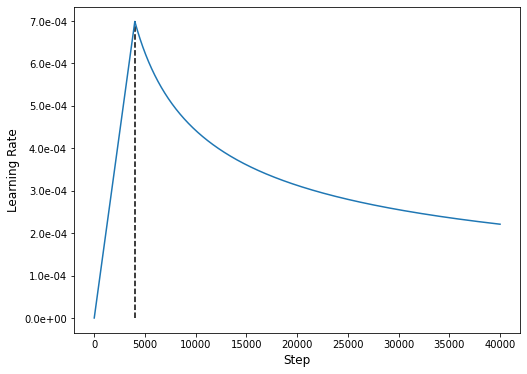

In [99]:
test_transformer_lr_schedule()

### Loss and Metrics

In [100]:
@tf.function
def entropy(p):
    return -tf.reduce_sum(tf.multiply(p, tf.math.log(p)), -1)


@tf.function
def crossentropy(p, q):
    return -tf.reduce_sum(tf.multiply(p, tf.math.log(q)), -1)


@tf.function
def kl_divergence(p, q):
    return tf.reduce_sum(tf.multiply(p, tf.math.log(tf.divide(p, q))), -1)


crossentropy_builtin = tf.keras.losses.CategoricalCrossentropy(
    reduction=tf.keras.losses.Reduction.NONE)

In [101]:
def test_crossentropy_builtin():
    p = tf.constant([[0.33, 0.33, 0.34], [0.02, 0.02, 0.96]])
    q = tf.constant([[0.3, 0.3, 0.4], [0.2, 0.3, 0.5]])

    print(f"p:\n{p}")
    print(f"q:\n{q}")
    print(f"entropy:\n{entropy(p)}")
    print(f"crossentropy:\n{crossentropy(p, q)}")
    print(f"crossentropy_builtin:\n{crossentropy_builtin(p, q)}")
    print(f"kl_divergence:\n{kl_divergence(p, q)}")
    print(f"kl_divergence check:\n{-entropy(p) + crossentropy(p, q)}")

In [102]:
test_crossentropy_builtin()

p:
[[0.33 0.33 0.34]
 [0.02 0.02 0.96]]
q:
[[0.3 0.3 0.4]
 [0.2 0.3 0.5]]
entropy:
[1.0985126  0.19567007]
crossentropy:
[1.1061609 0.7216895]
crossentropy_builtin:
[1.1061609 0.7216895]
kl_divergence:
[0.00764831 0.52601945]
kl_divergence check:
[0.00764823 0.52601945]


In [103]:
@tf.function
def smooth_labels(p, label_smoothing=0.1):
    vocab_size = tf.shape(p)[-1]
    vocab_size = tf.cast(vocab_size, tf.float32)
    return tf.add(tf.multiply(tf.subtract(1.0, label_smoothing), p),
                  tf.divide(label_smoothing, vocab_size))


@tf.function
def crossentropy_ls(p, q):
    return crossentropy(smooth_labels(p), q)


crossentropy_ls_builtin = tf.keras.losses.CategoricalCrossentropy(
    label_smoothing=0.1, reduction=tf.keras.losses.Reduction.NONE)

In [104]:
def test_crossentropy_ls_builtin():
    y_true = tf.constant([[1, 2, 0, 0], [2, 1, 1, 0]])
    p = tf.one_hot(y_true, 3)
    q = random.uniform((2, 4, 3))
    q = tf.divide(q, tf.reduce_sum(q, -1, True))

    # (batch_size, seq_len)
    print(f"y_true:\n{y_true}")
    # (batch_size, seq_len, vocab_size)
    print(f"p:\n{p}")
    # (batch_size, seq_len, vocab_size)
    print(f"smooth p:\n{smooth_labels(p)}")
    # (batch_size, seq_len, vocab_size)
    print(f"q:\n{q}")
    # (batch_size, seq_len)
    print(f"crossentropy:\n{crossentropy(p, q)}")
    # (batch_size, seq_len)
    print(f"crossentropy_builtin:\n{crossentropy_builtin(p, q)}")
    # (batch_size, seq_len)
    print(f"crossentropy_ls:\n{crossentropy_ls(p, q)}")
    # (batch_size, seq_len)
    print(f"crossentropy_ls_builtin:\n{crossentropy_ls_builtin(p, q)}")

In [105]:
test_crossentropy_ls_builtin()

y_true:
[[1 2 0 0]
 [2 1 1 0]]
p:
[[[0. 1. 0.]
  [0. 0. 1.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[0. 0. 1.]
  [0. 1. 0.]
  [0. 1. 0.]
  [1. 0. 0.]]]
smooth p:
[[[0.03333334 0.93333334 0.03333334]
  [0.03333334 0.03333334 0.93333334]
  [0.93333334 0.03333334 0.03333334]
  [0.93333334 0.03333334 0.03333334]]

 [[0.03333334 0.03333334 0.93333334]
  [0.03333334 0.93333334 0.03333334]
  [0.03333334 0.93333334 0.03333334]
  [0.93333334 0.03333334 0.03333334]]]
q:
[[[0.30951768 0.35787776 0.33260456]
  [0.2762179  0.55923486 0.16454726]
  [0.42121568 0.20454203 0.37424228]
  [0.20294477 0.5623063  0.23474893]]

 [[0.5276861  0.46658653 0.00572738]
  [0.13168487 0.75489956 0.11341554]
  [0.5868419  0.01515122 0.39800692]
  [0.40796205 0.10813049 0.48390746]]]
crossentropy:
[[1.0275638  1.8045574  0.86461025 1.5948215 ]
 [5.162497   0.28117058 4.1896744  0.8965811 ]]
crossentropy_builtin:
[[1.0275638  1.8045574  0.86461025 1.5948215 ]
 [5.162497   0.2811705  4.1896744  0.8965811 ]]
crossentropy_ls:
[[

#### Masked Crossentropy

In [106]:
class MaskedCrossentropy(tf.keras.losses.Loss):

    def __init__(self,
                 from_logits,
                 label_smoothing,
                 name="masked_crossentropy"):
        super().__init__(name=name)
        self.crossentropy = tf.keras.losses.CategoricalCrossentropy(
            from_logits,
            label_smoothing,
            reduction=tf.keras.losses.Reduction.NONE)

    @tf.function
    def call(self, y_true, y_pred):
        vocab_size = tf.shape(y_pred)[-1]
        y_true_oh = tf.one_hot(y_true, vocab_size)
        mask = padding_mask(y_true)
        losses = self.crossentropy(y_true_oh, y_pred)
        losses = tf.multiply(losses, tf.subtract(1.0, mask))
        loss = tf.divide(tf.reduce_sum(losses),
                         tf.reduce_sum(tf.subtract(1.0, mask)))
        return loss

In [107]:
def test_masked_crossentropy():
    y_true = random.uniform((32, 100), maxval=10000, dtype=tf.int64)
    y_pred = random.uniform((32, 100, 10000))
    y_pred = tf.divide(y_pred, tf.reduce_sum(y_pred, -1, True))
    crossentropy = MaskedCrossentropy(from_logits=False, label_smoothing=0.1)
    loss = crossentropy(y_true, y_pred)

    print(f"y_true shape: {y_true.shape}")
    print(f"y_pred shape: {y_pred.shape}")
    print(f"loss: {loss}")

In [108]:
test_masked_crossentropy()

y_true shape: (32, 100)
y_pred shape: (32, 100, 10000)
loss: 9.515403747558594


#### Masked Accuracy

In [109]:
class MaskedAccuracy(tf.keras.metrics.Metric):

    def __init__(self, name="masked_accuracy", **kwargs):
        super().__init__(name=name, **kwargs)
        self.accuracy = tf.keras.metrics.Mean()

    @tf.function
    def update_state(self, y_true, y_pred, sample_weight=None):
        mask = padding_mask(y_true)
        predictions = tf.argmax(y_pred, -1)
        accuracies = tf.equal(y_true, predictions)
        accuracies = tf.cast(accuracies, tf.float32)
        accuracies = tf.multiply(accuracies, tf.subtract(1.0, mask))
        accuracy = tf.divide(tf.reduce_sum(accuracies),
                             tf.reduce_sum(tf.subtract(1.0, mask)))
        self.accuracy.update_state(accuracy)

    def result(self):
        return self.accuracy.result()

    def reset_state(self):
        self.accuracy.reset_state()

In [110]:
def test_masked_accuracy():
    y_true = tf.constant([[1, 0, 2]], tf.int64)
    y_pred = tf.constant([[0.1, 0.8, 0.1], [0.8, 0.1, 0.1], [0.1, 0.8, 0.1]])
    accuracy = MaskedAccuracy()(y_true, y_pred)

    print(f"accuracy: {accuracy}")

In [111]:
test_masked_accuracy()

accuracy: 0.5


### Create, Compile and Fit Model

In [113]:
PARENT_CHECKPOINTS_DIR = f"{PERSISTENT_DIR}/checkpoints"
PARENT_LOGS_DIR = f"{PERSISTENT_DIR}/logs"

!mkdir -p "{PARENT_CHECKPOINTS_DIR}"
!mkdir -p "{PARENT_LOGS_DIR}"

In [114]:
training_counter = 0

In [115]:
def create_model():
    model = Transformer(
        d_model=128,
        vocab_size_enc=VOCAB_SIZE_SV,
        vocab_size_dec=VOCAB_SIZE_EN,
        N=4,
        h=8,
        d_k=16,  # d_model / h
        d_v=16,  # d_model / h
        d_ff=512,
        dropout_rate=0.1)
    return model

In [116]:
def create_compile_model():
    model = create_model()

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=TransformerLRSchedule(
            d_model=128,
            # ~3 epochs
            warmup_steps=10000),
        beta_1=0.9,
        beta_2=0.98,
        epsilon=1e-8)

    loss = MaskedCrossentropy(from_logits=True, label_smoothing=0.1)

    metrics = [MaskedAccuracy()]

    model.compile(optimizer, loss, metrics)

    return model

In [117]:
def create_compile_fit_model():
    global training_counter
    training_counter += 1

    model = create_compile_model()

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_masked_accuracy",
        min_delta=0.01,
        patience=3,
        verbose=1,
        mode="max")

    checkpoint_filepath = (f"{PARENT_CHECKPOINTS_DIR}"
                           f"/{EXPERIMENT_ID}_{training_counter:02d}"
                           f"/weights_{{epoch:02d}}")
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_masked_accuracy",
        save_best_only=True,
        save_weights_only=True,
        mode="max")

    log_dir = (f"{PARENT_LOGS_DIR}"
               f"/{EXPERIMENT_ID}_{training_counter:02d}")
    tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir)

    callbacks = [early_stopping_cb, checkpoint_cb, tensorboard_cb]

    history = model.fit(
        sv_en_train,
        validation_data=sv_en_val,
        epochs=32,  # 100000 steps
        callbacks=callbacks)

    return model, history

In [119]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-559bc4b6-2279-d844-98e0-0d4072669580)


In [120]:
model, history = create_compile_fit_model()

Epoch 1/32
3125/3125 [==============================] - 569s 168ms/step - loss: 6.9038 - masked_accuracy: 0.1561 - val_loss: 5.6814 - val_masked_accuracy: 0.2469
Epoch 2/32
3125/3125 [==============================] - 373s 119ms/step - loss: 5.4547 - masked_accuracy: 0.2755 - val_loss: 4.9100 - val_masked_accuracy: 0.3533
Epoch 3/32
3125/3125 [==============================] - 378s 121ms/step - loss: 4.7402 - masked_accuracy: 0.3795 - val_loss: 4.3003 - val_masked_accuracy: 0.4480
Epoch 4/32
3125/3125 [==============================] - 374s 120ms/step - loss: 4.2087 - masked_accuracy: 0.4633 - val_loss: 3.9117 - val_masked_accuracy: 0.5124
Epoch 5/32
3125/3125 [==============================] - 373s 119ms/step - loss: 3.8883 - masked_accuracy: 0.5133 - val_loss: 3.7549 - val_masked_accuracy: 0.5374
Epoch 6/32
3125/3125 [==============================] - 376s 120ms/step - loss: 3.7121 - masked_accuracy: 0.5405 - val_loss: 3.6650 - val_masked_accuracy: 0.5528
Epoch 7/32
3125/3125 [======

In [132]:
WEIGHTS_DIR = (f"{PARENT_CHECKPOINTS_DIR}"
               f"/{EXPERIMENT_ID}_{training_counter:02d}")

!tar -C "{WEIGHTS_DIR}" -czf "{WEIGHTS_DIR}/weights_11.tgz" weights_11.data-00000-of-00001 weights_11.index

In [130]:
!tensorboard dev upload --logdir "{PARENT_LOGS_DIR}" --name attention-is-all-you-need --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/p58eKim2QyOB6V890PBAcg/

[2021-12-30T16:03:49] Started scanning logdir.
[2021-12-30T16:03:50] Total uploaded: 77 scalars, 0 tensors, 1 binary objects (3.9 MB)
[2021-12-30T16:03:50] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/p58eKim2QyOB6V890PBAcg/


## Part 5: Inference

In [133]:
import matplotlib.pyplot as plt
import tensorflow as tf

### Pretrained Weights

In [134]:
MODEL_BASE_URL = ("https://storage.googleapis.com/jonaslalin"
                  "/models/attention-is-all-you-need")

VOCABS_URL = f"{MODEL_BASE_URL}/vocabs.tar"
WEIGHTS_URL = f"{MODEL_BASE_URL}/weights_11.tgz"

!wget -q -nc {VOCABS_URL}
!tar --skip-old-files -xf vocabs.tar
!wget -q -nc {WEIGHTS_URL}
!tar --skip-old-files -xf weights_11.tgz

In [135]:
VOCAB_SIZE_SV = 20000 + 2 + 2
MAX_SEQ_LEN_SV = 30 + 2

tokenize_sv = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE_SV - 2, output_sequence_length=MAX_SEQ_LEN_SV - 2)

In [136]:
tokenize_sv.set_vocabulary("sv.txt",)

vocab_sv = tokenize_sv.get_vocabulary()

In [137]:
VOCAB_SIZE_EN = 20000 + 2 + 2
MAX_SEQ_LEN_EN = 30 + 2

tokenize_en = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE_EN - 2, output_sequence_length=MAX_SEQ_LEN_EN - 2)

In [138]:
tokenize_en.set_vocabulary("en.txt",)

vocab_en = tokenize_en.get_vocabulary()

In [139]:
model = create_model()

model.load_weights("weights_11").expect_partial()

### Swedish to English Translator

In [140]:
@tf.function
def strip_padding(inputs):
    padding_idx = tf.where(tf.equal(inputs, 0))
    padding_idx = tf.squeeze(padding_idx, -1)
    if tf.shape(padding_idx)[0] > 0:
        return inputs[:padding_idx[0]]
    else:
        return inputs

In [141]:
class SvEnTranslator(tf.Module):

    def __init__(self,
                 model=model,
                 tokenize_sv=tokenize_sv,
                 name="sv_en_translator"):
        super().__init__(name=name)
        self.model = model
        self.tokenize_sv = tokenize_sv

    @tf.function
    def __call__(self, sv, max_loops=100):
        sv_tokens = self.tokenize_sv(sv)
        sv_tokens = add_start_end_sv(sv_tokens)

        en_tokens = tf.TensorArray(tf.int64, 0, True)
        en_tokens = en_tokens.write(0, SOS_TOKEN_EN)

        for i in tf.range(max_loops):
            y_pred, *_ = self.model.call2(
                enc_inputs=tf.expand_dims(sv_tokens, 0),
                dec_inputs=tf.expand_dims(en_tokens.stack(), 0))
            y_pred = tf.squeeze(y_pred, 0)
            predictions = tf.argmax(y_pred, -1)
            en_tokens = en_tokens.write(i + 1, predictions[-1])
            if predictions[-1] == EOS_TOKEN_EN:
                break

        (_, enc_block_1_attn_weights, dec_block_1_attn_weights,
         dec_block_2_attn_weights) = self.model.call2(
             enc_inputs=tf.expand_dims(sv_tokens, 0),
             dec_inputs=tf.expand_dims(en_tokens.stack()[:-1], 0))
        enc_block_1_attn_weights = tf.squeeze(enc_block_1_attn_weights, 1)
        dec_block_1_attn_weights = tf.squeeze(dec_block_1_attn_weights, 1)
        dec_block_2_attn_weights = tf.squeeze(dec_block_2_attn_weights, 1)

        sv_tokens = strip_padding(sv_tokens)
        en_tokens = en_tokens.stack()

        sv_words = detokenize_sv(sv_tokens)
        en_words = detokenize_en(en_tokens)

        return (sv_words, en_words, enc_block_1_attn_weights,
                dec_block_1_attn_weights, dec_block_2_attn_weights)

In [142]:
sv_en_translator = SvEnTranslator()

In [143]:
TRANSLATOR_DIR = f"{PERSISTENT_DIR}/sv_en_translator"

!mkdir -p "{TRANSLATOR_DIR}"

In [144]:
tf.saved_model.save(
    sv_en_translator, TRANSLATOR_DIR,
    sv_en_translator.__call__.get_concrete_function(tf.TensorSpec((),
                                                                  tf.string)))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/attention-is-all-you-need/sv_en_translator/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/attention-is-all-you-need/sv_en_translator/assets


In [145]:
!tar -C "{PERSISTENT_DIR}" -czf "{PERSISTENT_DIR}/sv_en_translator.tgz" sv_en_translator

### Attention Plots

In [146]:
TRANSLATOR_URL = f"{MODEL_BASE_URL}/sv_en_translator.tgz"

!wget -q -nc {TRANSLATOR_URL}
!tar --skip-old-files -xf sv_en_translator.tgz

In [147]:
sv_en_translator = tf.saved_model.load("sv_en_translator")

In [157]:
plot_counter = 0

In [158]:
def plot_attn_weights(sv_words, en_words, dec_block_2_attn_weights, layer,
                      head):
    global plot_counter
    plot_counter += 1

    xticklabels = [w.decode("utf-8") for w in sv_words.numpy()]
    yticklabels = [w.decode("utf-8") for w in en_words[1:].numpy()]

    plt.figure(figsize=(8, 6))
    plt.imshow(dec_block_2_attn_weights[layer - 1, head - 1, :, :len(sv_words)],
               cmap="viridis",
               interpolation="nearest",
               vmin=0,
               vmax=1)
    plt.xticks(ticks=range(len(sv_words)),
               labels=xticklabels,
               fontsize="large",
               rotation=90)
    plt.gca().xaxis.tick_top()
    plt.yticks(ticks=range(len(en_words[1:])),
               labels=yticklabels,
               fontsize="large")
    plt.xlabel(f"Layer {layer} · Head {head}", fontsize="x-large")
    plt.colorbar()
    plt.savefig(f"attention_{plot_counter}.svg", bbox_inches="tight")

In [159]:
def test_plot_attn_weights(sv, layer=4, head=8):
    (sv_words, en_words, enc_block_1_attn_weights, dec_block_1_attn_weights,
     dec_block_2_attn_weights) = sv_en_translator(sv)

    tf.print(sv_words, summarize=-1)
    tf.print(en_words, summarize=-1)
    print(f"sv_words shape: {sv_words.shape}")
    print(f"en_words shape: {en_words.shape}")
    print(f"enc_block_1_attn_weights shape:"
          f" {enc_block_1_attn_weights.shape}")
    print(f"dec_block_1_attn_weights shape:"
          f" {dec_block_1_attn_weights.shape}")
    print(f"dec_block_2_attn_weights shape:"
          f" {dec_block_2_attn_weights.shape}")

    plot_attn_weights(sv_words, en_words, dec_block_2_attn_weights, layer, head)

["[SOS]" "klimatförändringar" "utgör" "ett" "grundläggande" "hot" "mot" "arter" "och" "samhällen" "–" "och" "även" "människors" "överlevnad" "[EOS]"]
["[SOS]" "climate" "change" "represents" "a" "basic" "threat" "to" "species" "and" "societies" "–" "and" "also" "peoples" "survival" "[EOS]"]
sv_words shape: (16,)
en_words shape: (17,)
enc_block_1_attn_weights shape: (4, 8, 32, 32)
dec_block_1_attn_weights shape: (4, 8, 16, 16)
dec_block_2_attn_weights shape: (4, 8, 16, 32)


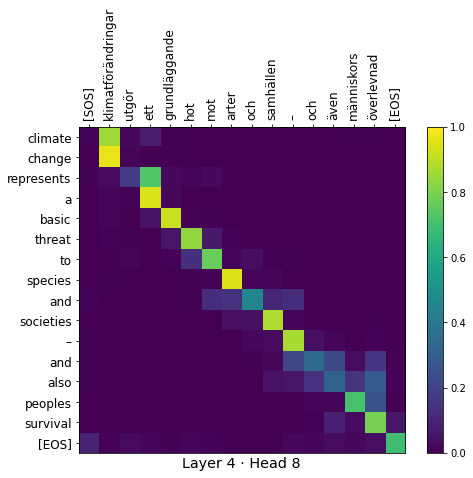

In [160]:
test_plot_attn_weights(
    tf.constant("Klimatförändringar utgör ett grundläggande hot"
                " mot arter och samhällen – och även människors överlevnad."))

["[SOS]" "ett" "annat" "påtagligt" "problem" "är" "att" "kvaliteten" "på" "vårt" "dricksvatten" "i" "västvärlden" "inte" "är" "så" "bra" "som" "många" "tror" "[EOS]"]
["[SOS]" "another" "problem" "is" "that" "the" "quality" "of" "our" "water" "in" "the" "west" "is" "not" "so" "good" "as" "many" "think" "[EOS]"]
sv_words shape: (21,)
en_words shape: (21,)
enc_block_1_attn_weights shape: (4, 8, 32, 32)
dec_block_1_attn_weights shape: (4, 8, 20, 20)
dec_block_2_attn_weights shape: (4, 8, 20, 32)


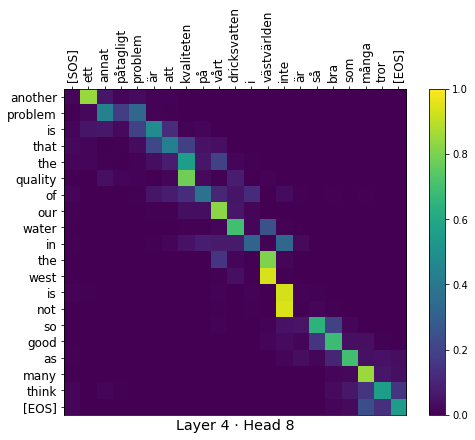

In [161]:
test_plot_attn_weights(
    tf.constant("Ett annat påtagligt problem"
                " är att kvaliteten på vårt dricksvatten"
                " i västvärlden inte är så bra som många tror."))